# Vigilant Asset Allocation (VAA)

Vigilant Asset Allocation (VAA) is introduced by Wouter J. Keller and Jan Willem Keuning in research paper "Breadth Momentum and Vigilant Asset Allocation (VAA): Winning More by Losing Less" (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3002624)

VAA strategy is an upgraded version of dual momentum with fast filter. 

1. We buy the strongest asset in terms of momentum in offensive assets.
2. If the most recent return of any of the offensive assets is negative, we go to defensive asset.

When it comes to computing returns' weights, it emphasizes the most recent 1 month return.

recent_return = 12 * (recent 1M return) + 4 * (recent 4M return) + 2 * (recent 6M return) + 1 * (recent 12M return)

In [59]:
import numpy as np
import pandas as pd
import src.fmp as fmp
import datetime as dt
import matplotlib.pyplot as plt

## Portfolio Assets

In [60]:
offensive = ['SPY', 'VEA', 'VWO', 'AGG']
defensive = ['SHY', 'IEF', 'LQD']

## Calculate monthly prices of offensive assets

In [61]:
offensive_monthly = pd.DataFrame()

for symbol in offensive:
    offensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]

## Offensive assets momentum

In [62]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in offensive_monthly.columns:
    print(symbol)
    curr = offensive_monthly[symbol][-1]
    m1_ret = (curr - offensive_monthly[symbol].shift(1)[-1]) / offensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - offensive_monthly[symbol].shift(3)[-1]) / offensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - offensive_monthly[symbol].shift(6)[-1]) / offensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - offensive_monthly[symbol].shift(12)[-1]) / offensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SPY
VEA
VWO
AGG


In [63]:
offensive_momentum = pd.DataFrame(momentum_data, index=offensive)
offensive_momentum['Score'] = 12 * offensive_momentum['1M'] + 4 * offensive_momentum['3M'] + 2 * offensive_momentum['6M'] + 1 * offensive_momentum['12M']

## Defensive Assets Momentum

In [64]:
defensive_monthly = pd.DataFrame()

for symbol in defensive:
    defensive_monthly[symbol] = fmp.get_monthly_prices(symbol)[symbol]

In [65]:
momentum_data = {'1M': [], '3M': [], '6M': [], '12M': []}
for symbol in defensive_monthly.columns:
    print(symbol)
    curr = defensive_monthly[symbol][-1]
    m1_ret = (curr - defensive_monthly[symbol].shift(1)[-1]) / defensive_monthly[symbol].shift(1)[-1]
    momentum_data['1M'].append(m1_ret)
    m3_ret = (curr - defensive_monthly[symbol].shift(3)[-1]) / defensive_monthly[symbol].shift(3)[-1]
    momentum_data['3M'].append(m3_ret)
    m6_ret = (curr - defensive_monthly[symbol].shift(6)[-1]) / defensive_monthly[symbol].shift(6)[-1]
    momentum_data['6M'].append(m6_ret)
    m12_ret = (curr - defensive_monthly[symbol].shift(12)[-1]) / defensive_monthly[symbol].shift(12)[-1]
    momentum_data['12M'].append(m12_ret)

SHY
IEF
LQD


In [66]:
defensive_momentum = pd.DataFrame(momentum_data, index=defensive)
defensive_momentum['Score'] = 12 * defensive_momentum['1M'] + 4 * defensive_momentum['3M'] + 2 * defensive_momentum['6M'] + 1 * defensive_momentum['12M']

## Backtesting

### VAA (Original Version: Offensive + Defensive)

#### Trading Logics

1. Compute vaa_momentum_scores using the function vaa_returns below.
2. If the momentum scores of all offensive assets are positive, we invest in one of the offensive assets which has the largest momentum score.
3. If any of momentum scores of offensive assets is negative, we don't invest in an offensive asset, and look at defensive assets.
4. If the momentum scores of all defensive assets are positive, we invest in one of the defensive assets which has the largest momentum score.
5. If any of momentum scores of defensive assets is negative, we don't inveset in a defensive asset, and hold cash for that month.

In [99]:
def vaa_returns(x):
    m1 = x / x.shift(1) - 1
    m3 = x / x.shift(3) - 1
    m6 = x / x.shift(6) - 1
    m12 = x / x.shift(12) - 1
    return (12 * m1 + 4 * m3 + 2 * m6 + 1 * m12) / 4

In [100]:
vaa_assets = ['SPY', 'VEA', 'VWO', 'AGG', 'SHY', 'IEF', 'LQD']
vaa_monthly_prices = pd.DataFrame()

for asset in vaa_assets:
    vaa_monthly_prices[asset] = fmp.get_monthly_prices(asset)[asset]
vaa_monthly_prices.head(10)

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2016-09-30,216.300003,37.410000,37.630001,112.419998,85.040001,111.879997,123.180000
2016-10-31,212.550003,36.509998,37.750000,111.300003,84.949997,110.059998,120.980003
2016-11-30,220.380005,35.959999,36.220001,108.239998,84.500000,105.260002,116.839996
2016-12-30,223.529999,36.540001,35.779999,108.059998,84.449997,104.820000,117.180000
2017-01-31,227.529999,37.880001,37.840000,108.290001,84.540001,105.050003,117.349998
2017-02-28,236.470001,38.279999,38.689999,108.769997,84.519997,105.650002,118.580002
2017-03-31,235.740005,39.299999,39.720001,108.489998,84.519997,105.589996,117.910004
2017-04-28,238.080002,40.169998,40.340000,109.250000,84.620003,106.599998,118.989998
2017-05-31,241.440002,41.540001,40.740002,109.760002,84.620003,107.320000,120.250000
2017-06-30,241.800003,41.320000,40.830002,109.510002,84.489998,106.610001,120.510002


In [101]:
vaa_monthly_mom = vaa_monthly_prices.copy()
vaa_monthly_mom = vaa_monthly_mom.apply(vaa_returns, axis=0)
vaa_monthly_mom.dropna(inplace=True)

In [102]:
for date in vaa_monthly_mom.index:
    if (vaa_monthly_mom.loc[date,['SPY', 'VEA', 'VWO', 'AGG']] < 0).any():
        # check defensive assets
        vaa_monthly_mom.loc[date, 'SPY'] = 0
        vaa_monthly_mom.loc[date, 'VEA'] = 0
        vaa_monthly_mom.loc[date, 'VWO'] = 0
        vaa_monthly_mom.loc[date, 'AGG'] = 0
        if (vaa_monthly_mom.loc[date,['SHY', 'IEF', 'LQD']] < 0).any():
            # hold cash
            vaa_monthly_mom.loc[date, 'SHY'] = 0
            vaa_monthly_mom.loc[date, 'IEF'] = 0
            vaa_monthly_mom.loc[date, 'LQD'] = 0
    else:
        # invest offensive asset
        vaa_monthly_mom.loc[date, 'SHY'] = 0
        vaa_monthly_mom.loc[date, 'IEF'] = 0
        vaa_monthly_mom.loc[date, 'LQD'] = 0
vaa_monthly_mom

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-11-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-12-29,0.183437,0.153360,0.283143,0.006620,0.000000,0.000000,0.000000
2018-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-06-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [103]:
mom_rank = vaa_monthly_mom.rank(axis=1, ascending=False)
for symbol in mom_rank.columns:
    mom_rank[symbol] = np.where(mom_rank[symbol] == 1, 1, 0)
mom_rank

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0,0,0,0,0,0,0
2017-10-31,0,0,0,0,0,0,0
2017-11-30,0,0,0,0,0,0,0
2017-12-29,0,0,1,0,0,0,0
2018-01-31,0,0,0,0,0,0,0
2018-02-28,0,0,0,0,0,0,0
2018-03-29,0,0,0,0,0,0,0
2018-04-30,0,0,0,0,0,0,0
2018-05-31,0,0,0,0,0,0,0
2018-06-29,0,0,0,0,0,0,0


In [147]:
# we have to shift the returns upward by one to align with momentum signal above.
vaa_monthly_rets = vaa_monthly_prices.pct_change()
vaa_monthly_rets.dropna(inplace=True)
vaa_monthly_rets = vaa_monthly_rets[mom_rank.index[0]:].shift(-1)
vaa_monthly_rets

,SPY,VEA,VWO,AGG,SHY,IEF,LQD
2017-09-29,0.023564,0.017738,0.024329,-0.001095,-0.001776,-0.003380,-0.000742
2017-10-31,0.030566,0.008601,-0.003361,-0.003563,-0.003084,-0.004333,-0.003880
2017-11-30,0.006981,0.006732,0.032149,0.002292,-0.002261,-0.001230,0.007375
2017-12-29,0.056359,0.047481,0.085602,-0.011250,-0.002862,-0.021502,-0.012257
2018-01-31,-0.036360,-0.051075,-0.053571,-0.012303,-0.002033,-0.010939,-0.024985
2018-02-28,-0.031290,-0.007625,-0.004028,0.004496,0.001438,0.009983,0.002733
2018-03-29,0.005168,0.012655,-0.027671,-0.011655,-0.003471,-0.014439,-0.018485
2018-04-30,0.024309,-0.014283,-0.023424,0.004340,0.002282,0.007965,0.002343
2018-05-31,0.001255,-0.028752,-0.054024,-0.001315,-0.001078,0.000000,-0.007966
2018-06-29,0.037047,0.022844,0.039810,-0.002445,-0.002159,-0.007121,0.010387


In [125]:
vaa_port = np.multiply(mom_rank, vaa_monthly_rets)
vaa_port_returns = vaa_port.sum(axis=1)
vaa_port_cum_returns = np.exp(np.log1p(vaa_port_returns).cumsum())[:-1]

### VAA (Modified: Relative Momentum Offensive Only)

#### Trading Logics

1. In this case, we only consider offensive assets.
2. Once we calculate momentum scores of offensive assets, and pick the one which has the largest score.
3. We are always invested in the market as we have to pick one offensive asset every month.

In [127]:
offensive_monthly_mom = offensive_monthly.copy()
offensive_monthly_mom = offensive_monthly_mom.apply(vaa_returns, axis=0)
offensive_monthly_mom.dropna(inplace=True)

# print(offensive_monthly_mom)

off_mom_rank = offensive_monthly_mom.rank(axis=1, ascending=False)
for symbol in off_mom_rank.columns:
    off_mom_rank[symbol] = np.where(off_mom_rank[symbol] < 2, 1, 0)
    
print(off_mom_rank)
    
offensive_monthly_rets = offensive_monthly.pct_change()
offensive_monthly_rets.dropna(inplace=True)
offensive_monthly_rets = offensive_monthly_rets[off_mom_rank.index[0]:].shift(-1)

offensive_port = np.multiply(off_mom_rank, offensive_monthly_rets)
offensive_port_returns = offensive_port.sum(axis=1)
offensive_port_cum_returns = np.exp(np.log1p(offensive_port_returns).cumsum())[:-1]
offensive_port_cum_returns.tail()

            SPY  VEA  VWO  AGG
2017-09-29    0    1    0    0
2017-10-31    0    0    1    0
2017-11-30    1    0    0    0
2017-12-29    0    0    1    0
2018-01-31    0    0    1    0
2018-02-28    1    0    0    0
2018-03-29    0    0    1    0
2018-04-30    0    1    0    0
2018-05-31    1    0    0    0
2018-06-29    1    0    0    0
2018-07-31    1    0    0    0
2018-08-31    1    0    0    0
2018-09-28    1    0    0    0
2018-10-31    0    0    0    1
2018-11-30    1    0    0    0
2018-12-31    0    0    0    1
2019-01-31    0    0    1    0
2019-02-28    1    0    0    0
2019-03-29    1    0    0    0
2019-04-30    1    0    0    0
2019-05-31    0    0    0    1
2019-06-28    1    0    0    0
2019-07-31    1    0    0    0
2019-08-30    0    0    0    1
2019-09-30    1    0    0    0
2019-10-31    0    1    0    0
2019-11-29    1    0    0    0
2019-12-31    0    0    1    0
2020-01-31    1    0    0    0
2020-02-28    0    0    0    1
2020-03-31    0    0    0    1
2020-04-

2021-03-31    1.166054
2021-04-30    1.173711
2021-05-28    1.153559
2021-06-30    1.181721
2021-07-30    1.216889
dtype: float64

### VAA (Modified: Dual momentum Offensive Only)

#### Trading Logics

1. In this case, we also consider only offensive assets like the previous case.
2. Once we calculate momentum scores of offensive assets, and we apply absolute momentum by checking the signs of momentum scores.
3. If any of the momentum scores of offensive assets is negative, we don't invest in any offensive asset, and hold cash for that month.

In [128]:
dual_offensive_monthly_mom = offensive_monthly.copy()
dual_offensive_monthly_mom = dual_offensive_monthly_mom.apply(vaa_returns, axis=0)
dual_offensive_monthly_mom.dropna(inplace=True)

print(dual_offensive_monthly_mom)

for date in dual_offensive_monthly_mom.index:
    if (dual_offensive_monthly_mom.loc[date] < 0).any():
        # print(date, ' negative')
        # check defensive assets
        dual_offensive_monthly_mom.loc[date, 'SPY'] = 0
        dual_offensive_monthly_mom.loc[date, 'VEA'] = 0
        dual_offensive_monthly_mom.loc[date, 'VWO'] = 0
        dual_offensive_monthly_mom.loc[date, 'AGG'] = 0

print(dual_offensive_monthly_mom)

dual_off_mom_rank = dual_offensive_monthly_mom.rank(axis=1, ascending=False)

print(dual_off_mom_rank)
for symbol in dual_off_mom_rank.columns:
    dual_off_mom_rank[symbol] = np.where(dual_off_mom_rank[symbol] == 1, 1, 0)
    
dual_offensive_monthly_rets = offensive_monthly.pct_change()
dual_offensive_monthly_rets.dropna(inplace=True)
dual_offensive_monthly_rets = dual_offensive_monthly_rets[dual_off_mom_rank.index[0]:].shift(-1)

dual_offensive_port = np.multiply(dual_off_mom_rank, dual_offensive_monthly_rets)
dual_offensive_port_returns = dual_offensive_port.sum(axis=1)
dual_offensive_port_cum_returns = np.exp(np.log1p(dual_offensive_port_returns).cumsum())[:-1]
dual_offensive_port_cum_returns

                 SPY       VEA       VWO       AGG
2017-09-29  0.157560  0.205761  0.105599 -0.023852
2017-10-31  0.205263  0.194931  0.209388 -0.008030
2017-11-30  0.261928  0.169920  0.096894 -0.024249
2017-12-29  0.183437  0.153360  0.283143  0.006620
2018-01-31  0.396244  0.318864  0.532226 -0.053773
2018-02-28  0.001977 -0.087000 -0.013051 -0.079343
2018-03-29 -0.054982  0.004691  0.096050 -0.019072
2018-04-30 -0.004120  0.027581 -0.121624 -0.077678
2018-05-31  0.112048 -0.040815 -0.099334 -0.009411
2018-06-29  0.073421 -0.129052 -0.295833 -0.033665
2018-07-31  0.208730  0.022742  0.025292 -0.024391
2018-08-31  0.244851 -0.088688 -0.250540 -0.001400
2018-09-28  0.167578  0.007181 -0.181042 -0.049966
2018-10-31 -0.220673 -0.441486 -0.490467 -0.058096
2018-11-30  0.023879 -0.140003  0.007042 -0.023107
2018-12-31 -0.475609 -0.453438 -0.282020  0.049551
2019-01-31  0.206734  0.148507  0.328945  0.059887
2019-02-28  0.094679  0.048242  0.002728  0.013797
2019-03-29  0.175381  0.059935 

2017-09-29    1.000000
2017-10-31    1.000000
2017-11-30    1.000000
2017-12-29    1.085602
2018-01-31    1.085602
2018-02-28    1.085602
2018-03-29    1.085602
2018-04-30    1.085602
2018-05-31    1.085602
2018-06-29    1.085602
2018-07-31    1.085602
2018-08-31    1.085602
2018-09-28    1.085602
2018-10-31    1.085602
2018-11-30    1.085602
2018-12-31    1.085602
2019-01-31    1.081445
2019-02-28    1.096191
2019-03-29    1.140973
2019-04-30    1.068212
2019-05-31    1.068212
2019-06-28    1.084363
2019-07-31    1.084363
2019-08-30    1.084363
2019-09-30    1.084363
2019-10-31    1.098940
2019-11-29    1.125338
2019-12-31    1.125338
2020-01-31    1.125338
2020-02-28    1.125338
2020-03-31    1.125338
2020-04-30    1.125338
2020-05-29    1.125338
2020-06-30    1.221933
2020-07-31    1.255457
2020-08-31    1.255457
2020-09-30    1.272007
2020-10-30    1.272007
2020-11-30    1.331813
2020-12-31    1.373540
2021-01-29    1.373540
2021-02-26    1.373540
2021-03-31    1.373540
2021-04-30 

### 60/40 Benchmark

In [18]:
assets = ['BND', 'SPY']

sixtyForty = pd.DataFrame()

for symbol in assets:
    sixtyForty[symbol] = fmp.get_monthly_prices(symbol)[symbol]

In [111]:
sixtyForty_returns = sixtyForty.pct_change()
sixtyForty_returns = sixtyForty_returns[mom_rank.index[0]:].shift(-1)
sixtyForty_weights = np.array([0.4, 0.6])
sixtyForty_returns['port'] = sixtyForty_returns.dot(sixtyForty_weights)
sixtyForty_returns.tail()

,BND,SPY,port
2021-04-30,0.000000,0.006566,0.003940
2021-05-28,0.007389,0.019093,0.014412
2021-06-30,0.010129,0.024412,0.018699
2021-07-30,-0.003458,0.029760,0.016473
2021-08-31,NaN,NaN,NaN


In [113]:
sixtyForty_cum_returns = np.exp(np.log1p(sixtyForty_returns['port']).cumsum())[:-1]
sixtyForty_cum_returns.tail()

2021-03-31    1.396188
2021-04-30    1.401689
2021-05-28    1.421889
2021-06-30    1.448478
2021-07-30    1.472338
Name: port, dtype: float64

### SPY (S&P 500)

In [130]:
benchmark_prices = fmp.get_monthly_prices('SPY')
benchmark_returns = benchmark_prices.pct_change()
benchmark_returns = benchmark_returns[mom_rank.index[0]:].shift(-1)
benchmark_cum_returns = np.exp(np.log1p(benchmark_returns).cumsum())[:-1]
benchmark_cum_returns.tail()

,SPY
2021-03-31,1.661028
2021-04-30,1.671934
2021-05-28,1.703857
2021-06-30,1.745452
2021-07-30,1.797397


In [140]:
combined_df = pd.DataFrame()
combined_df['VAA/Original'] = vaa_port_cum_returns
combined_df['VAA/Relative_Offensive'] = offensive_port_cum_returns
combined_df['VAA/Dual_Offensive'] = dual_offensive_port_cum_returns
combined_df['60/40'] = sixtyForty_cum_returns
combined_df['SPY'] = benchmark_cum_returns
combined_df.iloc[0] = 1
combined_df.index = pd.to_datetime(combined_df.index)
combined_df

,VAA/Original,VAA/Relative_Offensive,VAA/Dual_Offensive,60/40,SPY
2017-09-29,1.000000,1.000000,1.000000,1.000000,1.000000
2017-10-31,1.000000,1.014317,1.000000,1.030504,1.054850
2017-11-30,1.000000,1.021398,1.000000,1.035124,1.062214
2017-12-29,1.085602,1.108832,1.085602,1.065000,1.122079
2018-01-31,1.085602,1.049430,1.085602,1.036425,1.081280
2018-02-28,1.085602,1.016593,1.085602,1.018948,1.047447
2018-03-29,1.085602,0.988463,1.085602,1.017620,1.052860
2018-04-30,1.085602,0.974345,1.085602,1.034316,1.078454
2018-05-31,1.085602,0.975568,1.085602,1.033949,1.079807
2018-06-29,1.085602,1.011709,1.085602,1.055835,1.119810


In [143]:
stats_summary = pd.DataFrame(columns = ['Portfolio', 'CAGR (%)', 'MDD (%)', 'CAGR/MDD'])
beginning_month = combined_df.index[0].year
#beginning_month = dt.datetime.strptime(combined_df.index[0], "%Y-%m-%d").year

for col in combined_df.columns:
    # compute CAGR
    first_value = combined_df[col][0]
    last_value = combined_df[col][-1]  
    years = len(combined_df[col].index)/12    
    cagr = (last_value/first_value)**(1/years) - 1
    
    # compute MDD
    cumulative_returns = combined_df[col]
    previous_peaks = cumulative_returns.cummax()
    drawdown = (cumulative_returns - previous_peaks) / previous_peaks
    portfolio_mdd = drawdown.min()
    
    # save CAGR and MDD for each portfolio    
    stats_summary = stats_summary.append({'Portfolio': col,
                                         'CAGR (%)': cagr * 100,
                                         'MDD (%)': portfolio_mdd * 100,
                                         'CAGR/MDD': abs(cagr / portfolio_mdd).round(2)}, ignore_index=True) 

In [144]:
stats_summary.set_index('Portfolio', inplace=True)
stats_summary.sort_values('CAGR/MDD', ascending=False, inplace=True)
stats_summary

,CAGR (%),MDD (%),CAGR/MDD
Portfolio,,,
VAA/Original,11.852769,-6.377117,1.86
VAA/Dual_Offensive,9.110861,-6.377117,1.43
60/40,10.381311,-12.266932,0.85
SPY,16.149002,-19.918594,0.81
VAA/Relative_Offensive,5.139561,-27.549832,0.19


### Backtesting Performance Comparison (All Portfolios)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

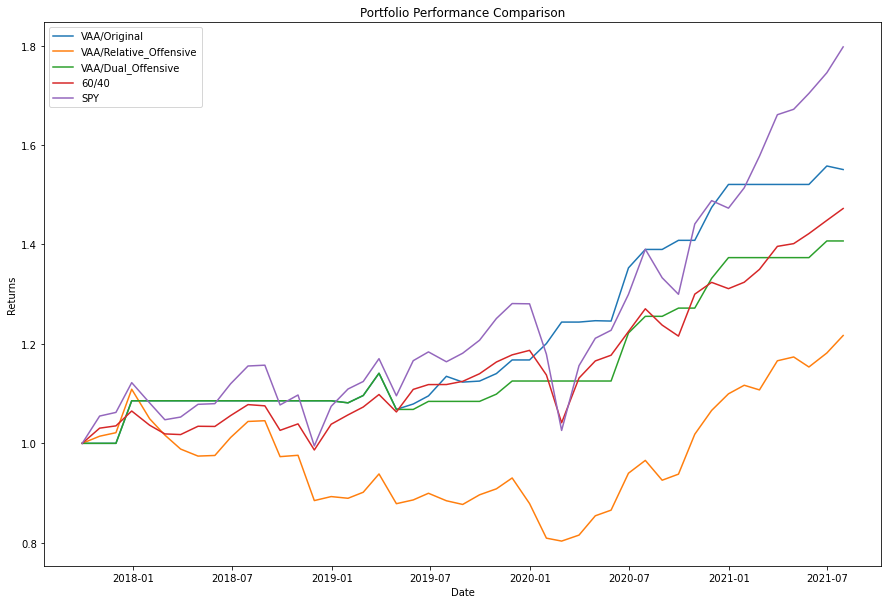

In [145]:
plt.figure(figsize=(15,10))
plt.plot(combined_df)
plt.legend(combined_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

### Backtesting Performance Comparison (Original VAA, 60/40, SPY)

Text(0.5, 1.0, 'Portfolio Performance Comparison')

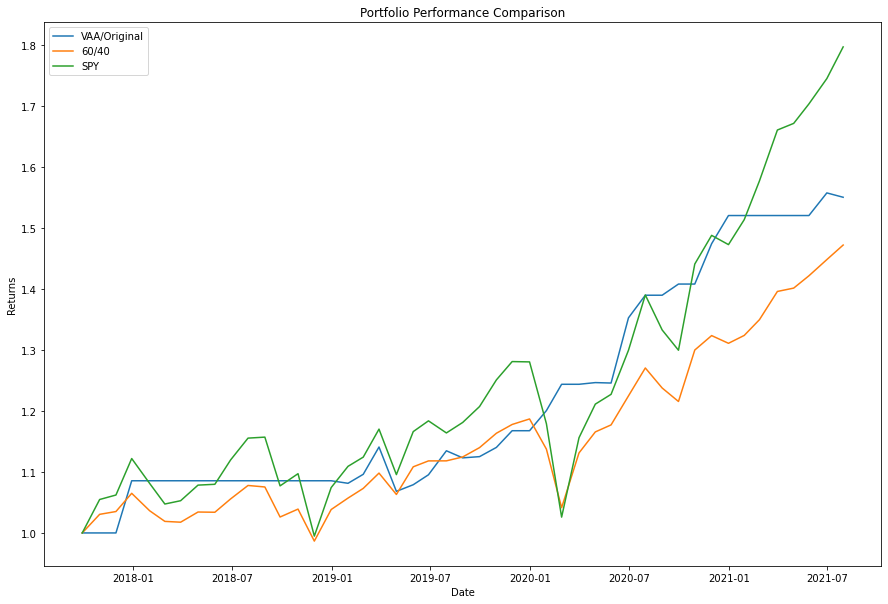

In [146]:
sub_df = combined_df[['VAA/Original', '60/40', 'SPY']]
plt.figure(figsize=(15,10))
plt.plot(sub_df)
plt.legend(sub_df.columns)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Portfolio Performance Comparison')

## Investment decision based on strategy algorithm

In [121]:
offensive_momentum

,1M,3M,6M,12M,Score
SPY,0.029760,0.075040,0.187191,0.292720,1.324382
VEA,0.013132,0.000763,0.092689,0.252926,0.598946
VWO,0.021914,-0.030624,-0.004953,0.181942,0.312503
AGG,-0.003435,0.013182,0.006242,-0.019515,0.004482


In [122]:
defensive_momentum

,1M,3M,6M,12M,Score
SHY,-0.000464,-0.000811,-0.000811,-0.003581,-0.014010
IEF,-0.004588,0.024213,0.012180,-0.035717,0.030446
LQD,-0.005220,0.027257,0.022908,-0.002212,0.089988


In [123]:
if (offensive_momentum['Score'] < 0).any():
    if (defensive_momentum['Score'] < 0).any():
        print('hold cash')
    else:
        first = defensive_momentum.sort_values(by='Score', ascending=False).index[0]
        print('invest in ' + first)
else:
    first = offensive_momentum.sort_values(by='Score', ascending=False).index[0]
    print('invest in ' + first)

invest in SPY
